In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
from torchvision.utils import make_grid

 ***Visualise transformed image***

In [ ]:
device = torch.device('cpu')

# %%
net = torch.hub.load('pytorch/vision:v0.9.0', 'vgg11', pretrained=True)
net = net.eval().to(device)

# we are not changing the network weights/biases in this lab
for param in net.parameters():
    param.requires_grad = False

id 208: Labrador retriever 69.5%
id 207: golden retriever 11.4%
id 209: Chesapeake Bay retriever 10.2%
id 163: bloodhound, sleuthhound 0.8%
id 178: Weimaraner 0.6%
id 227: kelpie 0.6%
id 222: kuvasz 0.5%
id 852: tennis ball 0.5%
id 159: Rhodesian ridgeback 0.4%
id 168: redbone 0.4%
id 243: bull mastiff 0.4%
id 215: Brittany spaniel 0.4%
id 238: Greater Swiss Mountain dog 0.3%
id 805: soccer ball 0.3%
id 248: Eskimo dog, husky 0.3%
id 211: vizsla, Hungarian pointer 0.3%
id 176: Saluki, gazelle hound 0.3%
id 166: Walker hound, Walker foxhound 0.2%
id 273: dingo, warrigal, warragal, Canis dingo 0.2%
id 167: English foxhound 0.2%


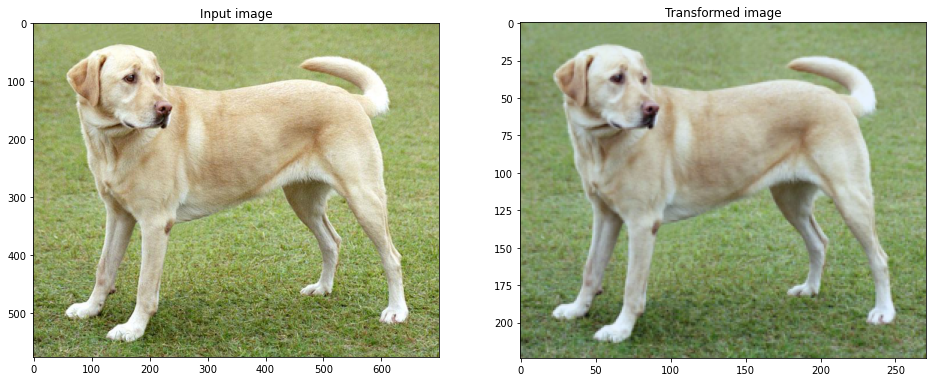

In [4]:
# Load the image, apply the classifier and report the top 10 classes.
# Visualise the input image and the transformed (resampled & normalised) tensor image.
# For the latter you may use the make_grid function mentioned above.

# image to tensor transform
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

# Load image
img = Image.open("dog.jpg")

# Original image
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
plt.sca(axs[0])
plt.title(f'Input image')
axs[0].imshow(img)
plt.title(f'Input image')
# Transformed image
img_t = transform(img).unsqueeze(0).cpu()
grid = make_grid(img_t, nrow=10, normalize=True, padding=1)
image = grid.cpu().numpy().transpose(1, 2, 0)
plt.sca(axs[1])
axs[1].imshow(image)
plt.title(f'Transformed image')

with torch.no_grad():
    score = net(img_t)

# Load labels
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# Rank predictions
_, indices = torch.sort(score, descending=True)
p = score.softmax(dim=1)[0]

# Top 10 classes
[print(f'id {idx.item()}:', classes[idx], f"{p[idx].item()*100:3.1f}%") for idx in indices[0][:20]]
pred = p.argmax().item()

***Activation channels***

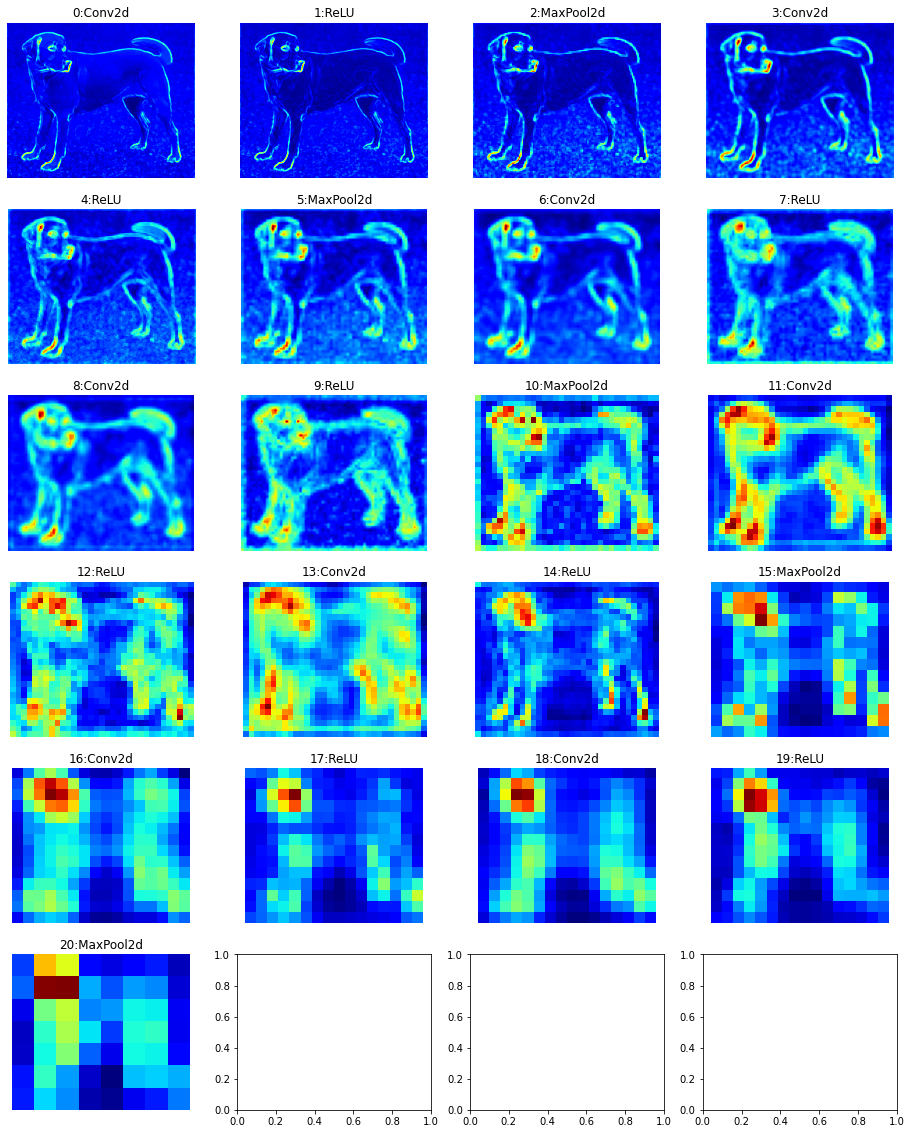

In [5]:
# For each layer l = 0,...,20 compute the feature map at that layer
# and the l2 norms of the channel activations (per pixel)
# and display them in tableau.
x = img_t # input image (tensor)
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(16, 20))
for (i,l) in enumerate(net.features):
    x = l.forward(x)
    f = (x.detach()**2).sum(dim=1).sqrt()[0]
    axs.flat[i].imshow(f.numpy(), cmap='jet')
    axs.flat[i].set_axis_off()
    axs.flat[i].set_title("{}:{}".format(i, l.__class__.__name__))

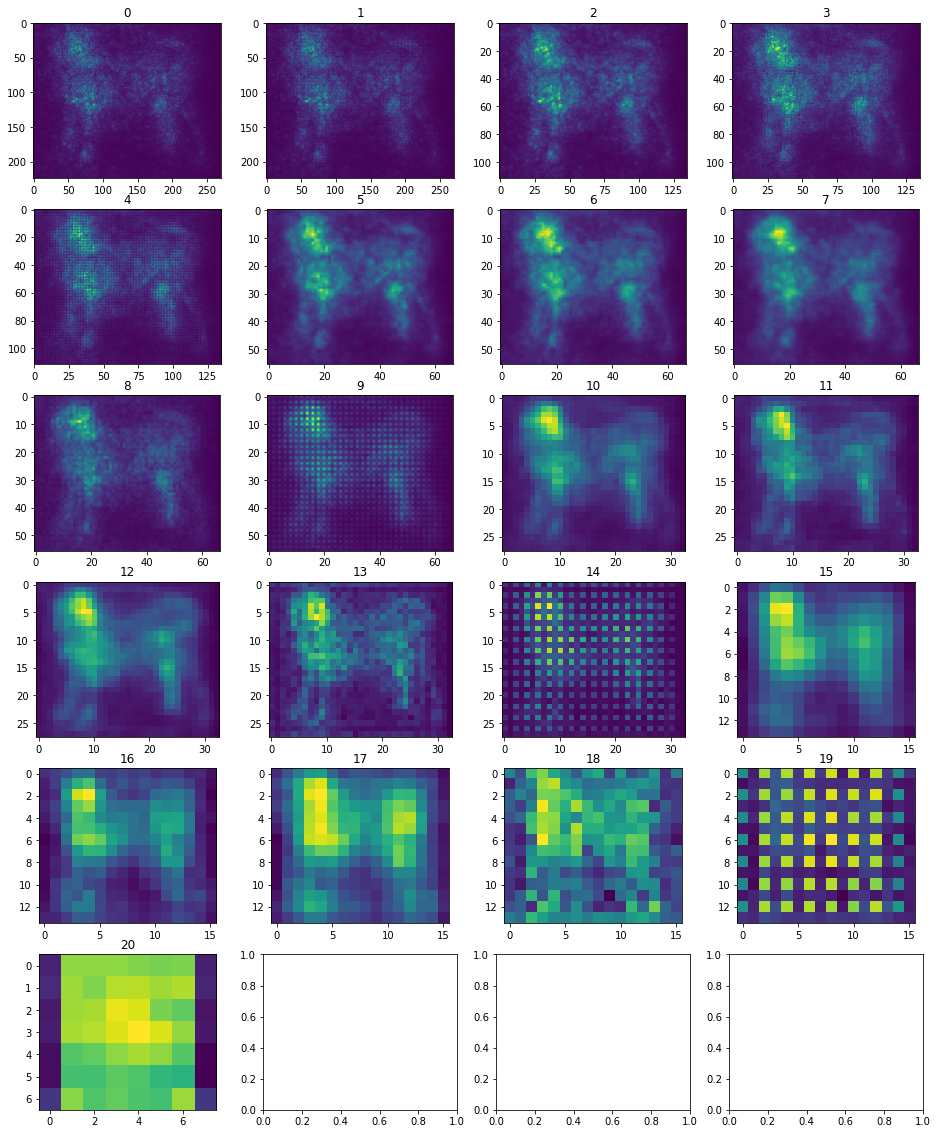

In [43]:
# Compute the gradient of the network classification score for the predicted class w.r.t. the feature maps
# l = 0,...,20.
# You could achieve this by forward iterating through the feature layers as above, additionally setting
# x.retain_grad() and appending each x to a list.
# Then you need to forward propagate through the rest of the network to its final output (score) and apply .backward() to compute the gradient w.r.t. the feature maps. Display a tableau with the results by showing the
# l2 norms of the channel gradients (per pixel).
net.eval()
net.cpu()
target = torch.tensor([pred])
criterion = nn.CrossEntropyLoss()

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(16, 20))
for i in range(0, 21):
    x = img_t
    # set requires_grad = True
    x.requires_grad = True

    net.zero_grad()

    # propagagte the network to its final output
    for j in range(0, i):
        x = net.features[j](x)

    y = net.features[i](x)
    y.retain_grad()

    z = y
    for j in range(i + 1, 21):
        z = net.features[j](z)

    z = net.avgpool(z)
    z = z.view((1, -1))

    # apply backward to compute gradient
    score = net.classifier(z)
    loss = criterion(score, target)
    loss.backward()

    grad = y.grad
    grad_norm = (grad ** 2).sum(dim=1).sqrt()[0].cpu().numpy()
    plt.sca(axs[i//4, i%4])
    im = plt.imshow(grad_norm)

    plt.title(f'{i}')

**Visualization of activation patterns for deep features**

In [ ]:
# https://www.baeldung.com/cs/cnn-receptive-field-size
def receptive_field(layer, net):
    r = 0
    S = 1
    for i in range(layer+1):
        l = net.features[i]
        if isinstance(l, torch.nn.Conv2d):
            r = r + (l.weight.size(2) - 1)*S
        if isinstance(l, torch.nn.MaxPool2d):
            r = r * 2 + 1
            S *=2
    return r

In [23]:
apool = torch.nn.AvgPool2d(3, padding=0, stride=1)
apad = torch.nn.ReplicationPad2d(1)
epsilon = 0.008
def regularization(x, S):
    with torch.no_grad():
      xx = apool(apad(x))
      diff = x - xx
      dn = torch.linalg.norm(diff.flatten(2), dim=2, ord=1.0) / (S * S)
      if dn.max() > epsilon:
        x.data[dn > epsilon] = xx[dn > epsilon]
    return x

def activation_max(layer):
    out = []

    S = receptive_field(layer, net) # The size should be equal to the receptive field of the unit in the target layer.
    channels = 3
    learning_rate = 0.001

    out_channels = net.features[layer].out_channels
    for channel in range(out_channels):
        x = torch.zeros((1, channels, S, S))
        x.requires_grad = True
        # set optimizer and set net to zero grad
        optimizer = torch.optim.Adam([x], lr=learning_rate, weight_decay=1e-4)
        net.zero_grad()
        net.eval()

        dev = torch.device('cpu')

        # run the gradient ascent for a fixed number of steps.
        for _ in range(0,50):
            y = x.to(dev)
            optimizer.zero_grad()

            # Forward propagate x through the network to compute the feature map y of the target layer.
            for (i, l) in enumerate(net.features):
                y = l.forward(y)

                if i == layer: break
            # Select the centrally located pixel and the target channel in the feature map y.
            # Note: Hope that this is central pixel
            criterion = (-y[0, channel, :, :][len(y[0, channel, :, :])//2].mean())

            # use the Adam optimizer to maximize the selected feature (i.e. forward-backward loop with optimizer steps).
            # maximize
            criterion.backward()
            optimizer.step()

            x = regularization(x, S)

        # Find such an activating image x for each channel of the target layer and display them in a panel.
        out.append(x.data.cpu())

    # Plot results
    nrows = (out_channels + 10 - 1) // 10
    fig, axs = plt.subplots(nrows=nrows, ncols=10, figsize=(20, nrows * 2))
    for i in range(out_channels):
        plt.sca(axs[i // 10, i % 10])
        img = out[i]
        grid = make_grid(img, nrow=10, normalize=True, padding=1)
        image = grid.cpu().numpy().transpose(1, 2, 0)
        plt.sca(axs[i// 10, i%10])
        plt.imshow(image)

    return out

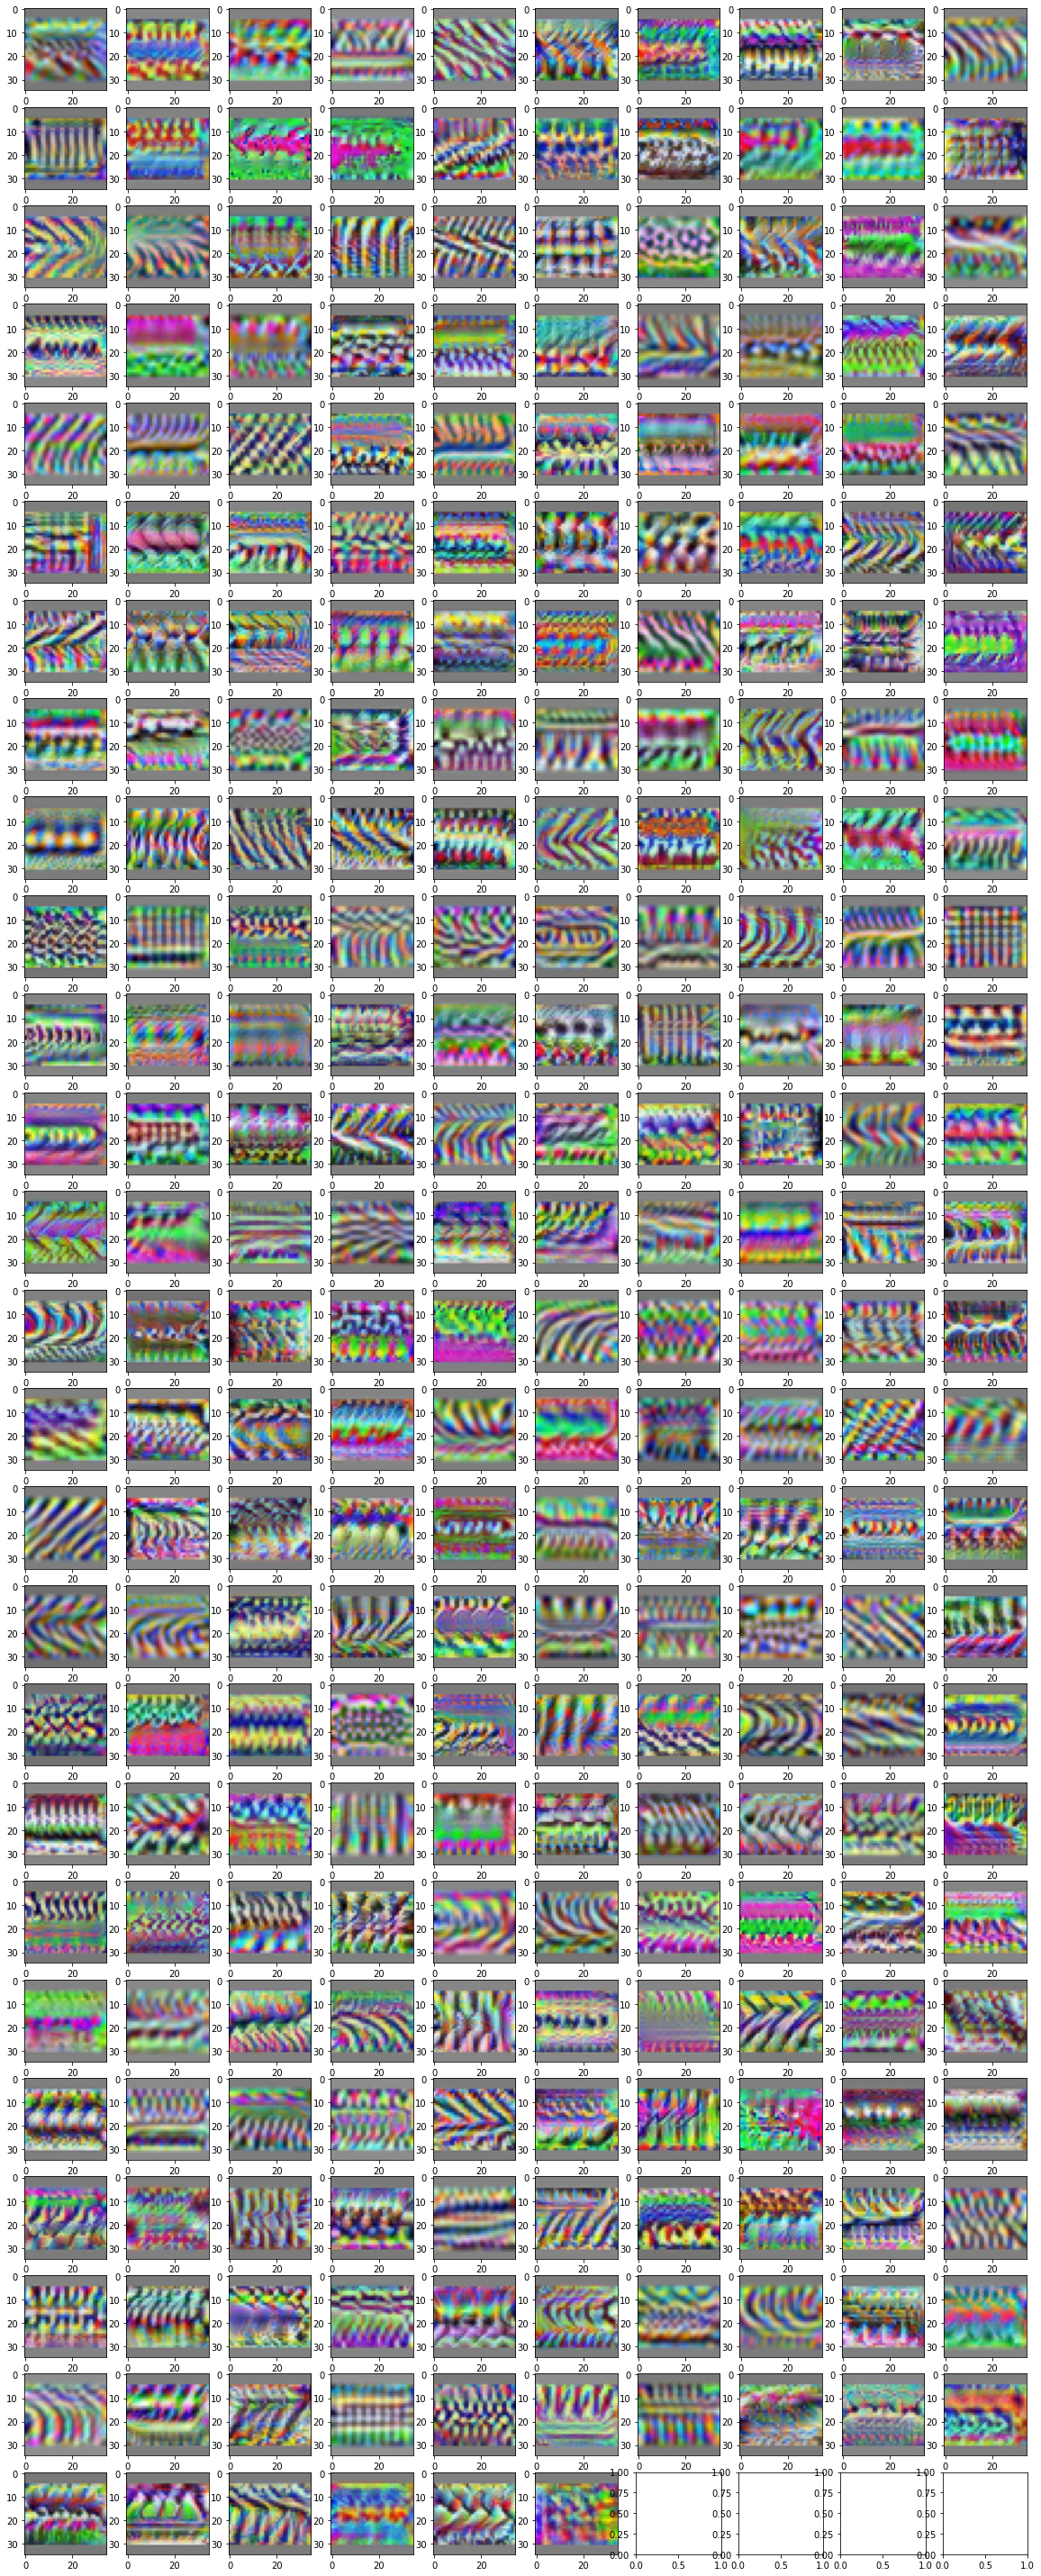

In [24]:
x = activation_max(layer=8)

**Targeted iterative adversarial attack**

In [35]:
# Your task is to implement a targeted iterative adversarial attack.
# 1. Choose a clean image which is correctly classified by the net
# (e.g. the image of the labrador retriever).
img = Image.open("dog.jpg")
img_t = transform(img).unsqueeze(0).cpu()
eps = 20.
step = 1e-3

x0 = img_t.detach().clone()

# 2. Choose a target class different from the true class (e.g. 892: wall clock) and fix an ε > 0.
target_idx = 892

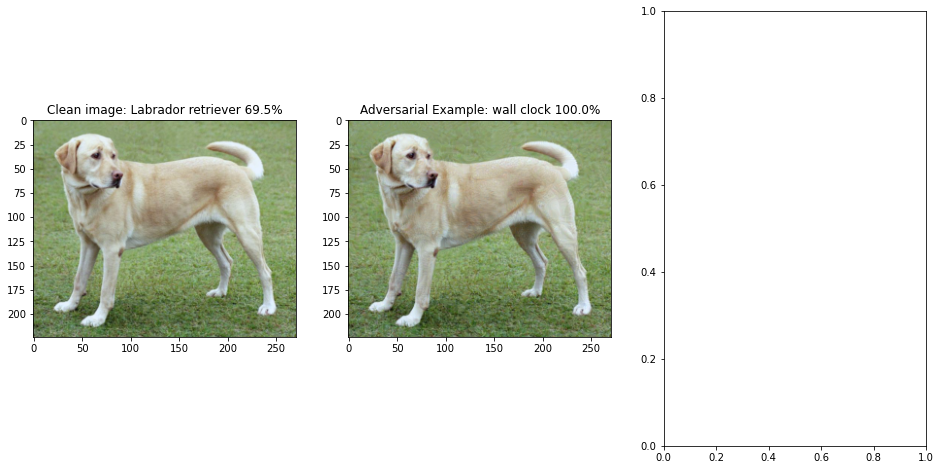

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

# Clean image
x0 = img_t.detach().clone()
score = net.forward(x0)
p = score.softmax(dim=1)[0]
idx = p.argmax()

plt.sca(axs[0])
grid = make_grid(img_t, nrow=10, normalize=True, padding=1)
image = grid.cpu().numpy().transpose(1, 2, 0)
axs[0].imshow(image)
plt.title(f'Clean image: {classes[idx]} {p[idx]*100:3.1f}%')

# Adversarial image
x = x0.clone()
x.requires_grad = True

noise = torch.zeros_like(img_t)
# Implement a projected gradient ascent that aims to maximize the softmax output of the target class w.r.t. the input image, but constrains the search to the ε-ball around the clean image.
# Start the optimization from the clean image.
for _ in range(100):
    score = net.forward(x)
    p = score.softmax(dim=1)[0]

    target = -p[target_idx]
    grad = torch.autograd.grad(target,[x])[0]
    x = x - grad.sign() * step
    noise += grad.sign() * step

    dx = (x.detach() - x0)
    dn = dx.flatten().norm()
    div = torch.clamp(dn/eps, min=1.0)
    dx = dx / div
    x.data = x0 + dx

plt.sca(axs[1])
grid = make_grid(x, nrow=10, normalize=True, padding=1)
image = grid.cpu().numpy().transpose(1, 2, 0)
axs[1].imshow(image)
score = net.forward(x)
p = score.softmax(dim=1)[0]
idx = p.argmax()
plt.title(f'Adversarial Example: {classes[idx]} {p[idx]*100:3.1f}%');